In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
breast = datasets.load_breast_cancer()

In [4]:
X = breast.data
y = breast.target

Scatterplot двух произвольно взятых признаков. Можно сменить a и b, подписи к осям автоматически сменятся.

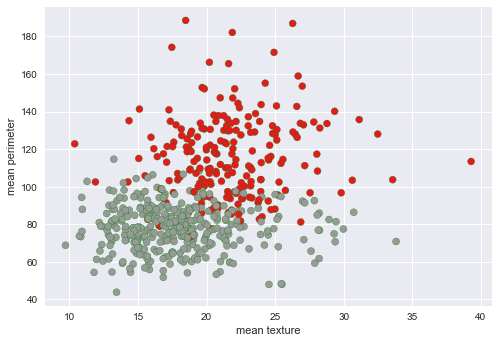

In [5]:
a = 1
b = 2 #feature numbers


plt.scatter(X[:, a], X[:, b], c=y, cmap=plt.cm.Set1,
            edgecolor='g')

plt.xlabel(breast.feature_names[a])

plt.ylabel(breast.feature_names[b])


plt.show()

Нормализуем наш датасет. Построим матрицу ковариации для нормализованного датасета.

In [6]:
X_std = StandardScaler().fit_transform(X)

mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

По диагонали матрицы ковариации лежат дисперсии исходных признаков.

In [7]:
cov_mat.diagonal()


array([ 1.00176056,  1.00176056,  1.00176056,  1.00176056,  1.00176056,
        1.00176056,  1.00176056,  1.00176056,  1.00176056,  1.00176056,
        1.00176056,  1.00176056,  1.00176056,  1.00176056,  1.00176056,
        1.00176056,  1.00176056,  1.00176056,  1.00176056,  1.00176056,
        1.00176056,  1.00176056,  1.00176056,  1.00176056,  1.00176056,
        1.00176056,  1.00176056,  1.00176056,  1.00176056,  1.00176056])

In [8]:
np.var(X_std, axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.])

Это же соотношение сохраняется и в случае с ненормализованным датасетом.

In [9]:
cov_mat1 = np.cov(X.T)


In [10]:
cov_mat1.diagonal()


array([  1.24189201e+01,   1.84989087e+01,   5.90440480e+02,
         1.23843554e+05,   1.97799700e-04,   2.78918740e-03,
         6.35524790e-03,   1.50566077e-03,   7.51542821e-04,
         4.98487228e-05,   7.69023519e-02,   3.04315949e-01,
         4.08789584e+00,   2.06943158e+03,   9.01511400e-06,
         3.20702887e-04,   9.11198238e-04,   3.80724191e-05,
         6.83328983e-05,   7.00169156e-06,   2.33602242e+01,
         3.77764828e+01,   1.12913085e+03,   3.24167385e+05,
         5.21319833e-04,   2.47547707e-02,   4.35240905e-02,
         4.32074068e-03,   3.82758354e-03,   3.26209378e-04])

In [11]:
np.var(X, axis=0)

array([  1.23970943e+01,   1.84663974e+01,   5.89402799e+02,
         1.23625903e+05,   1.97452073e-04,   2.78428549e-03,
         6.34407875e-03,   1.50301462e-03,   7.50222008e-04,
         4.97611152e-05,   7.67671984e-02,   3.03781123e-01,
         4.08071149e+00,   2.06579462e+03,   8.99927022e-06,
         3.20139261e-04,   9.09596835e-04,   3.80055080e-05,
         6.82128053e-05,   6.98938631e-06,   2.33191693e+01,
         3.77100918e+01,   1.12714643e+03,   3.23597671e+05,
         5.20403629e-04,   2.47112650e-02,   4.34475982e-02,
         4.31314711e-03,   3.82085668e-03,   3.25636075e-04])

Необходимо продемонстрировать какие параметры (стандартизированного) датасета лучше объясняют дисперсию в исходных данных.

In [12]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [13]:
tot = sum(eig_vals)
eig_vals_with_names = list(zip(eig_vals, range(len(eig_vals))))
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
names = [breast.feature_names[nme] for value, nme in sorted(eig_vals_with_names, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = go.Bar(
        x=names,
        y=var_exp,
        showlegend=False)

trace2 = go.Scatter(
        x=names, 
        y=cum_var_exp,
        name='cumulative explained variance')

data = go.Data([trace1, trace2])

layout=go.Layout(
        yaxis=go.YAxis(title='Explained variance in percent'),
        title='Explained variance by different parameters of the full dataset')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Первые 7 параметров (из 30) объясняют 91 % дисперсии исходных данных. Имеет смысл оставить их, а остальные отбросить.

In [14]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort()
eig_pairs.reverse()

matrix_w = np.hstack((eig_pairs[i][1].reshape(30,1) for i in range(7)))


Новый датасет X_new - проекция матрицы занчений X_std на подпространство

In [15]:
X_new = X_std.dot(matrix_w)
X_new.shape

(569, 7)

Посчитаем след матрицы ковариации исходного (но уже стандартизированного) датасета (30 параматров) и нового датасета (7 параметров)

In [16]:
trace_reduced = np.cov(X_new.T).diagonal().sum()

In [17]:
trace_full = np.cov(X_std.T).diagonal().sum()

Первые 7 признаков объясняли около 91% дисперсии данных. След ковариационной матрицы датасета со сниженной размерностью составляет 91% от следа исходной ковариационной матрицы.

In [18]:
trace_reduced / trace_full

0.91009530069673172

Построим матрицу ковариации и график % объясненной дисперсии для датасета X_new.

In [19]:
cov_reduced = np.cov(X_new.T)
eig_vals_red, eig_vecs_red = np.linalg.eig(cov_reduced)

In [20]:
tot = sum(eig_vals_red)

var_exp_red = [(i / tot)*100 for i in sorted(eig_vals_red, reverse=True)]

cum_var_exp_red = np.cumsum(var_exp_red)

trace1 = go.Bar(
        x=['PC %s' %i for i in range(1,8)],
        y=var_exp_red,
        showlegend=False)

trace2 = go.Scatter(
        x=['PC %s' %i for i in range(1,8)], 
        y=cum_var_exp_red,
        name='cumulative explained variance')

data = go.Data([trace1, trace2])

layout=go.Layout(
        yaxis=go.YAxis(title='Explained variance in percent'),
        title='Explained variance by different parameters of the reduced dataset')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [21]:
from collections import Counter
Counter(breast.target)

Counter({0: 212, 1: 357})

Разделим исходную выборку на тренировочную и тестовую в соотношении 90/10. Запустим на ней алгоритм kNN. Поставим определенный random state, чтобы удобнее было сравнивать различные результаты.

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
accuracy_score(y_test, y_pred)

             precision    recall  f1-score   support

    class 0       1.00      0.83      0.91        24
    class 1       0.89      1.00      0.94        33

avg / total       0.94      0.93      0.93        57



0.92982456140350878

То же самое с нормализованным датасетом

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.1, random_state=12)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
accuracy_score(y_test, y_pred)

             precision    recall  f1-score   support

    class 0       1.00      0.88      0.93        24
    class 1       0.92      1.00      0.96        33

avg / total       0.95      0.95      0.95        57



0.94736842105263153

In [25]:
from sklearn.model_selection import cross_val_score, cross_val_predict

Сделаем 10-fold кросс-валидацию и оценим качество модели

In [26]:
scores = cross_val_score(neigh, X, y, cv=10)
"Cross-validated scores:", scores


('Cross-validated scores:',
 array([ 0.9137931 ,  0.86206897,  0.89473684,  0.94736842,  0.94736842,
         0.94736842,  0.96491228,  0.94642857,  0.91071429,  0.92857143]))

In [27]:
"дисперсия точности: ", np.var(scores) 

('дисперсия точности: ', 0.00087540468326816425)

In [28]:
pred = cross_val_predict(neigh, X, y, cv=10)
accuracy_score(pred, y)

0.92618629173989453

In [29]:
from sklearn.model_selection import KFold

In [64]:
dct = {}

kf = KFold(n_splits=10, shuffle=True)


for nbr in range(1, 10):
    neigh = KNeighborsClassifier(n_neighbors=nbr)
    for i in range(10):
        if nbr not in dct:
            dct[nbr] = []
        pred = cross_val_predict(neigh, X, y, cv=kf)
        
        res =  accuracy_score(pred, y)
        
        dct[nbr].append(res)

In [65]:
dct_mean = {i: np.mean(dct[i]) for i in dct}

In [66]:
dct_mean

{1: 0.91616871704745184,
 2: 0.91001757469244282,
 3: 0.92601054481546574,
 4: 0.92688927943760979,
 5: 0.93391915641476275,
 6: 0.93145869947275917,
 7: 0.93163444639718807,
 8: 0.93427065026362066,
 9: 0.9332161687170476}

In [67]:
var = np.var(list(dct_mean.values()))
var

6.526762368262777e-05

In [68]:
trace = go.Scatter(
    x = list(range(1, 10)),
    y = [dct_mean[i] for i in range(1, 10)],
    mode = 'lines+markers',
    name = 'lines+markers'
)

data = [trace]
layout = dict(title = 'Model efficiency with different number of neighbours',
              xaxis = dict(title = 'Number of neighbours'),
              yaxis = dict(title = 'Accuracy score'),
              )

fig = dict(data=data, layout=layout)
iplot(fig)

Исследуем какое количество соседей дает лучшую точность предсказания

In [35]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [36]:
from sklearn.pipeline import Pipeline
knn_params = {'knn__n_neighbors': [2, 5, 8, 10]}
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [37]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
cv=5, n_jobs=-1,
verbose=True)

In [38]:
knn_grid.fit(X_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'knn__n_neighbors': [2, 5, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [39]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 5}, 0.96491228070175439)

In [40]:
accuracy_score(y_test, knn_grid.predict(X_test))

0.98245614035087714

In [41]:
trace = go.Scatter(
    x = [2,5,8,10],
    y = knn_grid.cv_results_['mean_test_score'],
    mode = 'lines+markers',
    name = 'lines+markers'
)

data = [trace]
layout = dict(title = 'Model efficiency with different number of neighbours',
              xaxis = dict(title = 'Number of neighbours'),
              yaxis = dict(title = 'Accuracy score'),
              )

fig = dict(data=data, layout=layout)
iplot(fig)

Повторим эти же действия для X_reduced

In [42]:
pca = PCA(n_components=7)
X_reduced = pca.fit_transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.1, random_state=12)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
accuracy_score(y_test, y_pred)

             precision    recall  f1-score   support

    class 0       1.00      0.83      0.91        24
    class 1       0.89      1.00      0.94        33

avg / total       0.94      0.93      0.93        57



0.92982456140350878

С 7 компонентами первоначальное предсказание имеет такие же результаты, как и полноценный датасет с 30 параметрами.

Исследуем какое количество соседей дает лучшую точность предсказания

In [44]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [45]:
from sklearn.pipeline import Pipeline
knn_params = {'knn__n_neighbors': [2, 5, 8, 10]}
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [46]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
cv=5, n_jobs=-1,
verbose=True)

In [47]:
knn_grid.fit(X_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'knn__n_neighbors': [2, 5, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [48]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 2}, 0.8771929824561403)

In [49]:
accuracy_score(y_test, knn_grid.predict(X_test))

0.94736842105263153

In [50]:
trace = go.Scatter(
    x = [2,5,8,10],
    y = knn_grid.cv_results_['mean_test_score'],
    mode = 'lines+markers',
    name = 'lines+markers'
)

data = [trace]
layout = dict(title = 'Model efficiency with different number of neighbours for X_reduced with 7 PCs',
              xaxis = dict(title = 'Number of neighbours'),
              yaxis = dict(title = 'Accuracy score'),
              )

fig = dict(data=data, layout=layout)
iplot(fig)

C 7 главными компонентами точномсть предсказания упала с 98 до 94 процентов


Напишем функцию, которая будет итеративно тестировать точность предсказаний на кросс-валидационной сетке для датасета с разным числом оставшихся главных компонент

In [51]:
def test_pca_numbers(components=3):
    pca = PCA(n_components=components)
    X_reduced = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.1, random_state=12)
    knn_params = {'knn__n_neighbors': [2, 5, 8, 10]}
    knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
    knn_grid = GridSearchCV(knn_pipe, knn_params,
                        cv=5, n_jobs=-1,
                        verbose=False)
    knn_grid.fit(X_test, y_test)
    score = accuracy_score(y_test, knn_grid.predict(X_test))
    report = {
        'best_params' : knn_grid.best_params_,
        'best_score on training set' : knn_grid.best_score_,
        'accuracy score on test set': score,
        'Number of PCs' : components
    }
    
    return report
    
    
    
    

Протестируем нашу функцию на разном количестве компонент

In [52]:
comps = [2, 3, 5, 7, 9, 14, 20]

for i in comps:
    print(test_pca_numbers(components=i))

{'Number of PCs': 2, 'accuracy score on test set': 0.89473684210526316, 'best_score on training set': 0.8771929824561403, 'best_params': {'knn__n_neighbors': 10}}
{'Number of PCs': 3, 'accuracy score on test set': 0.8771929824561403, 'best_score on training set': 0.8771929824561403, 'best_params': {'knn__n_neighbors': 5}}
{'Number of PCs': 5, 'accuracy score on test set': 0.98245614035087714, 'best_score on training set': 0.96491228070175439, 'best_params': {'knn__n_neighbors': 2}}
{'Number of PCs': 7, 'accuracy score on test set': 0.94736842105263153, 'best_score on training set': 0.8771929824561403, 'best_params': {'knn__n_neighbors': 2}}
{'Number of PCs': 9, 'accuracy score on test set': 0.94736842105263153, 'best_score on training set': 0.84210526315789469, 'best_params': {'knn__n_neighbors': 2}}
{'Number of PCs': 14, 'accuracy score on test set': 0.96491228070175439, 'best_score on training set': 0.91228070175438591, 'best_params': {'knn__n_neighbors': 2}}
{'Number of PCs': 20, 'a

Наиболее высокая точность прогноза у датасета с 5 главными компонентами и настройкой алгоритма kNN на число соседей, равное двум